# Predicting profit and Driving Business Insights using Iowa spirits sales

# Modeling

## 1. Introduction

This is the fourth Notebook of this project. We will cover 2 main business problems in it:
1. The main target and goal of our project is using time series analysis and predictions to forecast Iowa's Dept. of Commerce profits from spirits Sales. We plan to follow a series of methods and tools to conduct the analysis, transformation and modeling of our data:

* Time series decomposition
    - Level
    - Trend
    - Seasonality
    - Noise

* Stationarity
    - AC and PAC plots
    - Rolling mean and std
    - Dickey-Fuller test
    
* Making the time series stationary
    - Difference transform
    - Smoothing
    - Moving average

* Models Tested
   - Simple Exponential Smoothing
   - Exponential Smoothing
   - ARMA (0, MA)
   - Autoregressive Moving Average (ARMA)
   - Seasonal autoregressive integrated moving average (SARIMA)


   
2. Lastly, we want to assist a hypothetical liquor store owner in Iowa in expanding to new locations throughout the state. For this we will choose a hypothetical chains of stores and we will try to find the optimal location for his new store using the data available.

* A first step is to take clean data regarding State of Iowa Demographics per County, City and Zip Code. We will also need information regarding income per capita.

* Then we have to create relevant features or metrics that will allow us to classify the areas of interest(these may be cities, counties or Zip Codes)

* If needed we can use Tableau's EDA using the existing geolocation feature to identify hot spots more easily.

* We can then choose our ten top possible locations.

* Basen on the classification of the top hot spots and the features collected we can then use Regression algorithms from our Supervised Learning toolkit to predict Sales for each of those locations and making recomendation based on that.

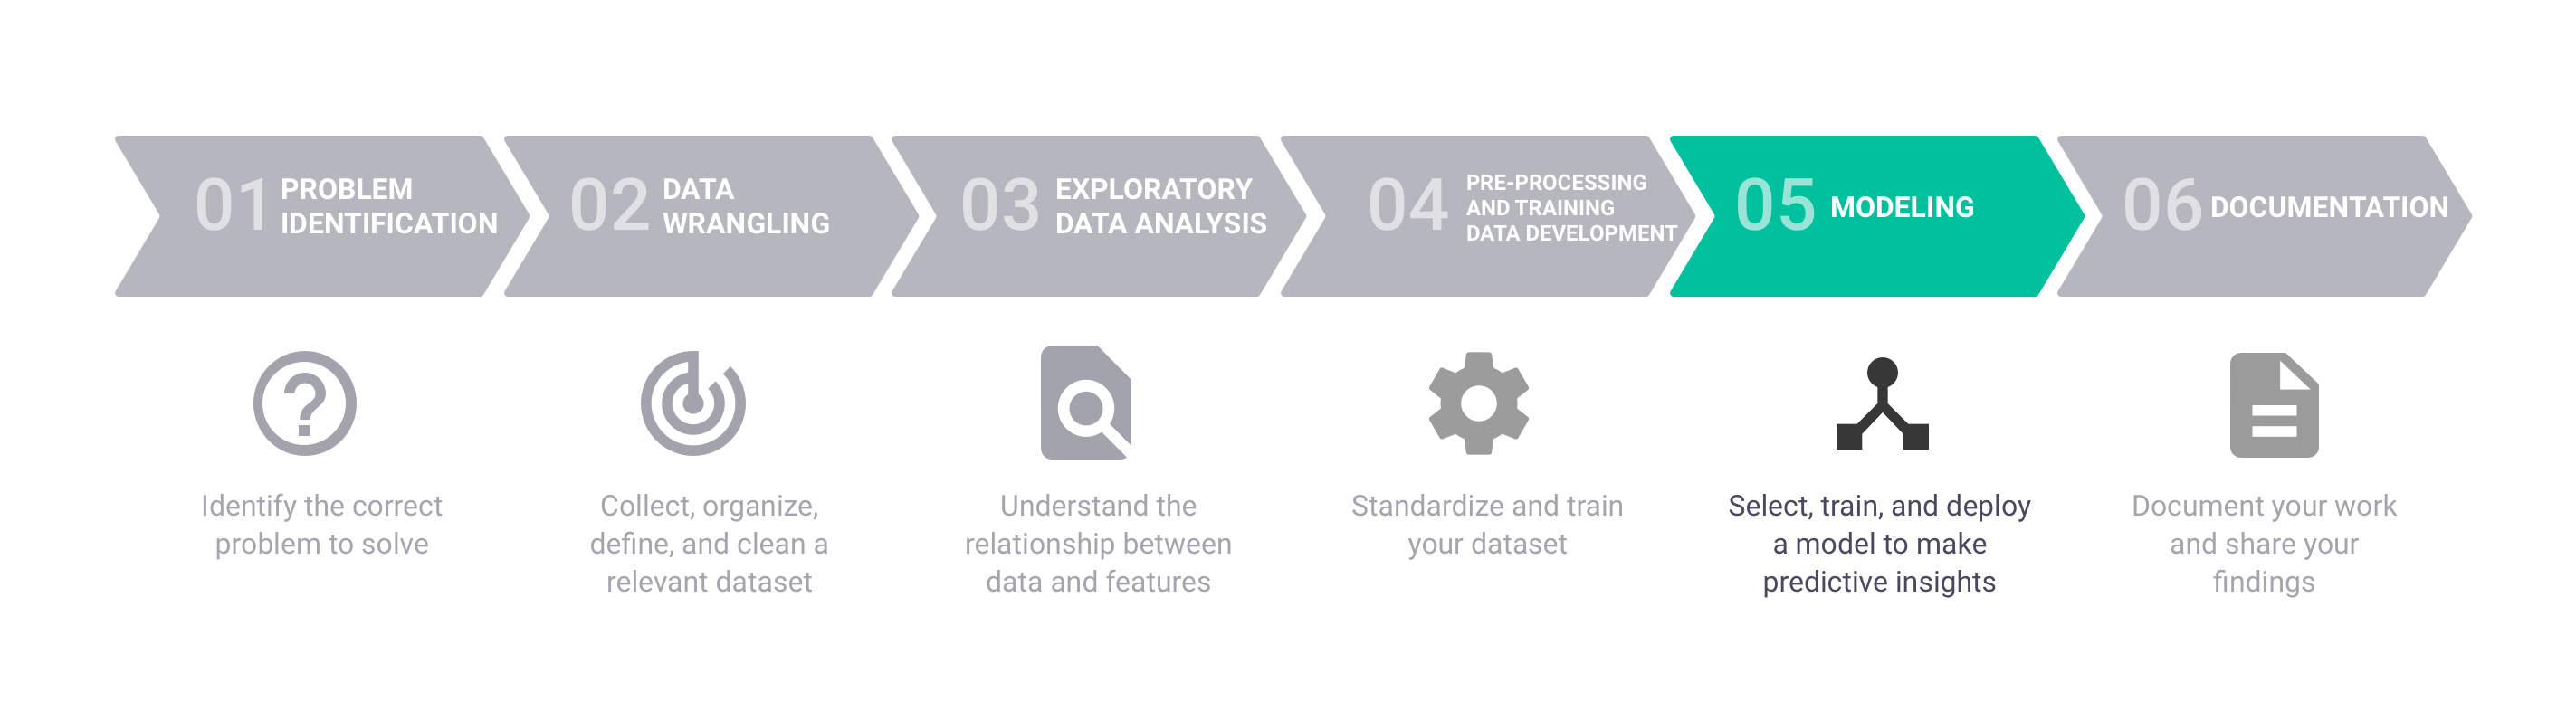

In [51]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)
import seaborn as sns
sns.set_theme(style="whitegrid")
from pylab import rcParams

import datetime as dt
import calendar
np.random.seed(123)

import itertools
import math
import missingno as msno

from scipy.signal import argrelextrema
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import lightgbm
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


## Final Data Preparation for Time Series Analysis

In [2]:
df = pd.read_csv('../data/interim/state_profit_df.csv', parse_dates = True)

In [3]:
df = df[['Date', 'state_profit']].set_index('Date')
df

,state_profit
Date,
2016-03-24,81.00
2016-03-24,52.08
2016-03-24,159.36
2016-03-17,150.00
2016-03-24,26.52
...,...
2017-11-17,9.63
2018-05-23,17.50
2018-07-26,671.79


In [4]:
df = df.groupby('Date').sum()
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-09,312103.77
2012-01-10,300781.67
...,...
2021-06-25,577218.72
2021-06-27,14283.09
2021-06-28,651212.68


In [5]:
df.index = pd.to_datetime(df.index)

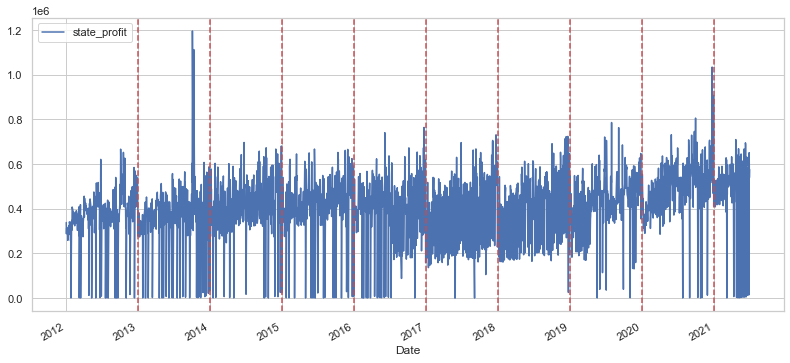

In [6]:
df.plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> It seems that we have a lot of 0 values, especially from 2012 to the middle of 2016, when this trend started to disapear untilthe middle of 2021 when we start to see again a lot of 0s 

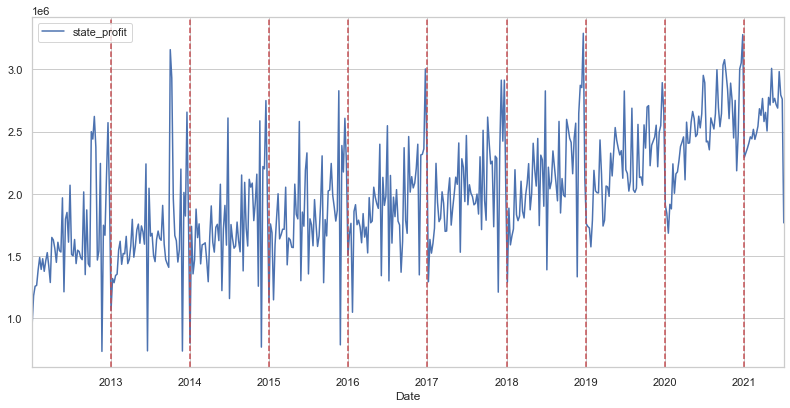

In [7]:
df.resample('W').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> Looking at the Profit values aggregated per Week, we can see a certain sesonality, with big drops in winter folowed by huge spikes up right before the year end.

> We can also see that there is an apparent increase in the profit over the years, with this growing faster in the past 2 and a half years.


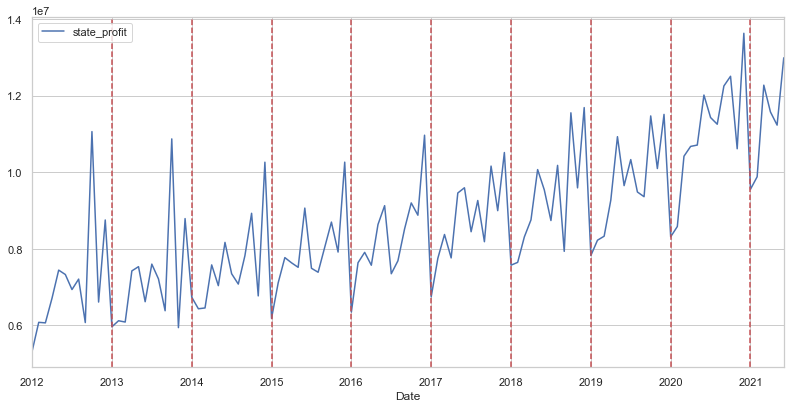

In [8]:
df.resample('M').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> Aggregated by month, the sesonality is clearer, with a big spike in December. Let's look at the data as well.

In [9]:
df.resample('M').sum().tail(12).T

Date,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30
state_profit,11425543.92,11251787.28,12249942.76,12503554.69,10610884.63,13625794.29,9554119.39,9879334.94,12271348.59,11572070.73,11228231.77,12985685.08


Finnaly, let's look at the data aggregated by Quarted and by year.

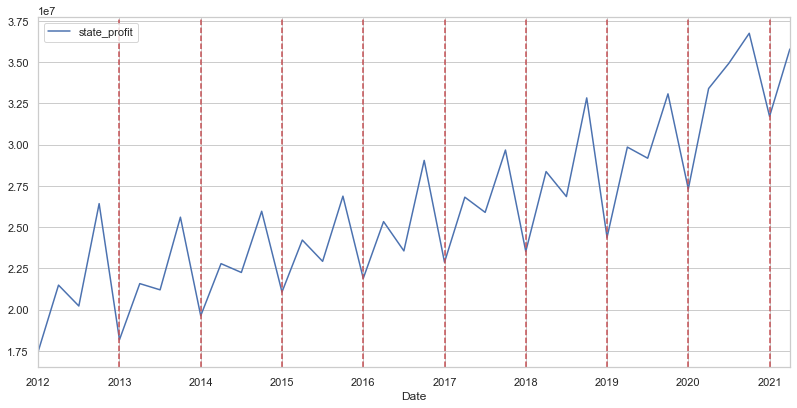

In [10]:
df.resample('Q').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

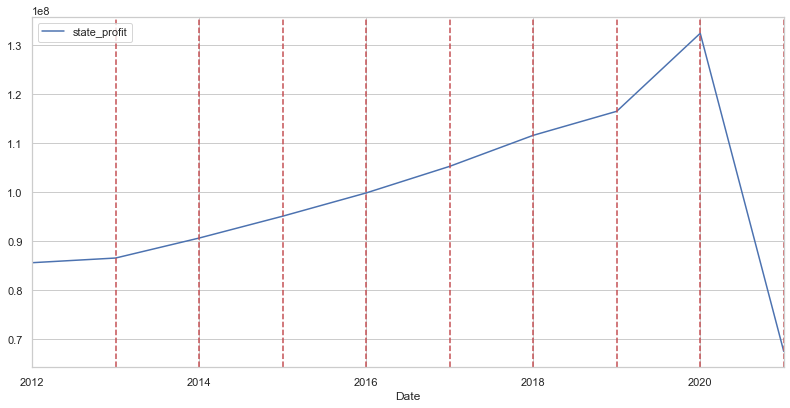

In [11]:
df.resample('Y').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

We can see that because for 2021 we have onyl the sales until 2021-06-30 we can't see the trend for this last period.

Let's just multiply 2021 with 2 since our data has 6 month of sales and see the trend.

In [12]:
df_yearly = df.resample('Y').sum()
df_yearly

,state_profit
Date,
2012-12-31,8.557850e+07
2013-12-31,8.653254e+07
2014-12-31,9.060711e+07
2015-12-31,9.506513e+07
2016-12-31,9.980815e+07
2017-12-31,1.052320e+08
2018-12-31,1.115549e+08
2019-12-31,1.164576e+08
2020-12-31,1.323686e+08


In [13]:
df_yearly.loc['2021-12-31',:] = df_yearly.loc['2021-12-31',:] *2

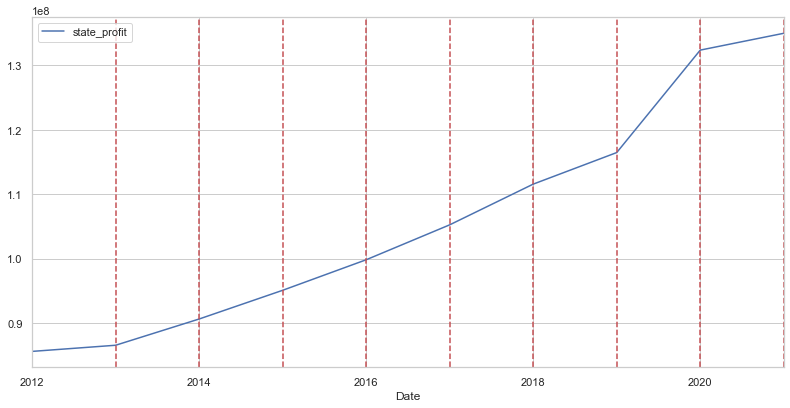

In [14]:
df_yearly.plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

We can see that the trend is rather constant, apart from 2020, the year of the Pandemic, when the state_profit had increased substantially  more than in the preceding years.

## Profit Analysis by Month and Day of Week

Let's get other date features from our data Field.

In [15]:
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-09,312103.77
2012-01-10,300781.67
...,...
2021-06-25,577218.72
2021-06-27,14283.09
2021-06-28,651212.68


In [16]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df

,state_profit,year,month,day_of_month,day_of_week
Date,,,,,
2012-01-03,338343.67,2012,1,3,1
2012-01-04,287668.70,2012,1,4,2
2012-01-05,314128.76,2012,1,5,3
2012-01-09,312103.77,2012,1,9,0
2012-01-10,300781.67,2012,1,10,1
...,...,...,...,...,...
2021-06-25,577218.72,2021,6,25,4
2021-06-27,14283.09,2021,6,27,6
2021-06-28,651212.68,2021,6,28,0


We will explore how is the profit ditributed on days of week

In [17]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [18]:
subset = df.groupby(['day_of_week','year'])[['state_profit']].sum()
subset = subset.reset_index()
subset

,day_of_week,year,state_profit
0,0,2012,20431958.13
1,0,2013,22550127.36
2,0,2014,26299267.89
3,0,2015,25930322.07
4,0,2016,24563930.47
...,...,...,...
58,5,2020,630088.39
59,5,2021,700428.92
60,6,2019,39802.73
61,6,2020,7320.68


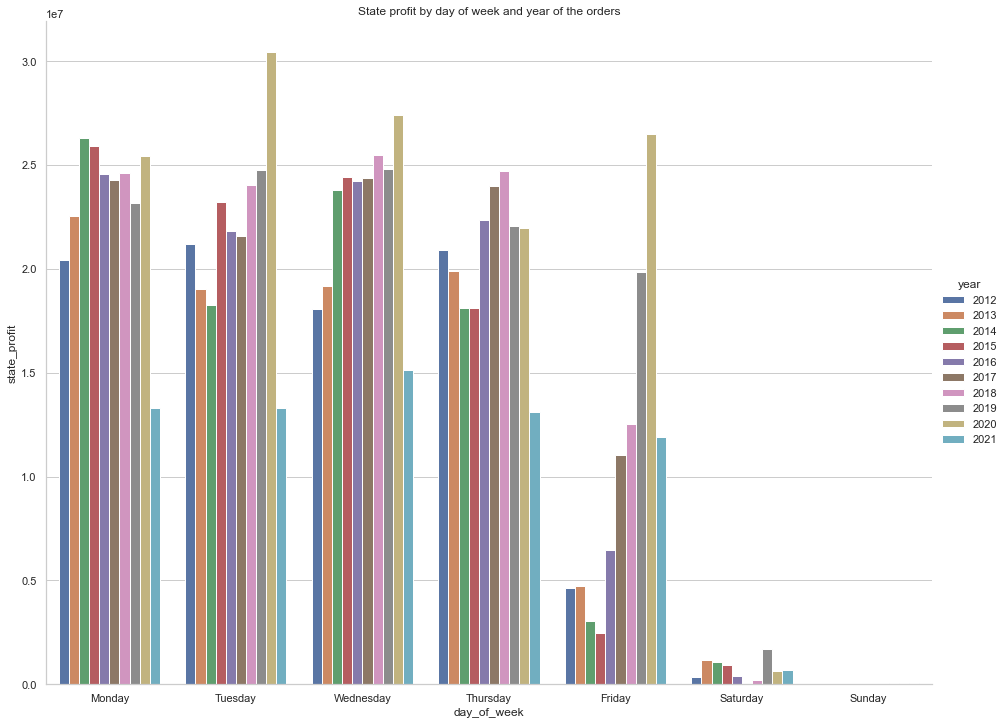

In [19]:
sns.catplot(x="day_of_week", y="state_profit", hue="year",data=subset, kind = 'bar', height = 10, aspect = 1.3)
plt.xticks(range(7), days_order)
plt.title('State profit by day of week and year of the orders')
plt.show()

We can observe that:
1. There are no sales happening on Sunday.
2. There are very few sales on Saturday.
3. If before 2019 there were way fewer Sales(and profit) On Friday orders, since then we can see taht the amount of profit from Friday orders is within the same values as those from any other workday.
4. Sales on Tuesday, Wednesday and Friday were at the highest values in 2020.

In [20]:
subset = df.groupby(['month','year'])[['state_profit']].sum()
subset = subset.reset_index()
subset

,month,year,state_profit
0,1,2012,5320216.31
1,1,2013,5962644.02
2,1,2014,6736369.66
3,1,2015,6181739.35
4,1,2016,6346672.56
...,...,...,...
109,12,2016,10964568.61
110,12,2017,10512415.80
111,12,2018,11685628.39
112,12,2019,11507912.76


Let's see what were the most profitable months

In [21]:
subset.sort_values('state_profit').tail(10)

,month,year,state_profit
112,12,2019,11507912.76
93,10,2018,11549361.31
39,4,2021,11572070.73
111,12,2018,11685628.39
58,6,2020,12013064.33
86,9,2020,12249942.76
29,3,2021,12271348.59
95,10,2020,12503554.69
59,6,2021,12985685.08
113,12,2020,13625794.29


In our top 10 best selling months we have 3 Decembers(2018,2019,2020), 2 Novembers(2018 and 2020), 2 June(2020 and 2021) plus one March(2021), April(2021) and September(2020).

As for the year, we have 2 months in 2018, one in 2019, 4 in 2020 and 3 in 2021.

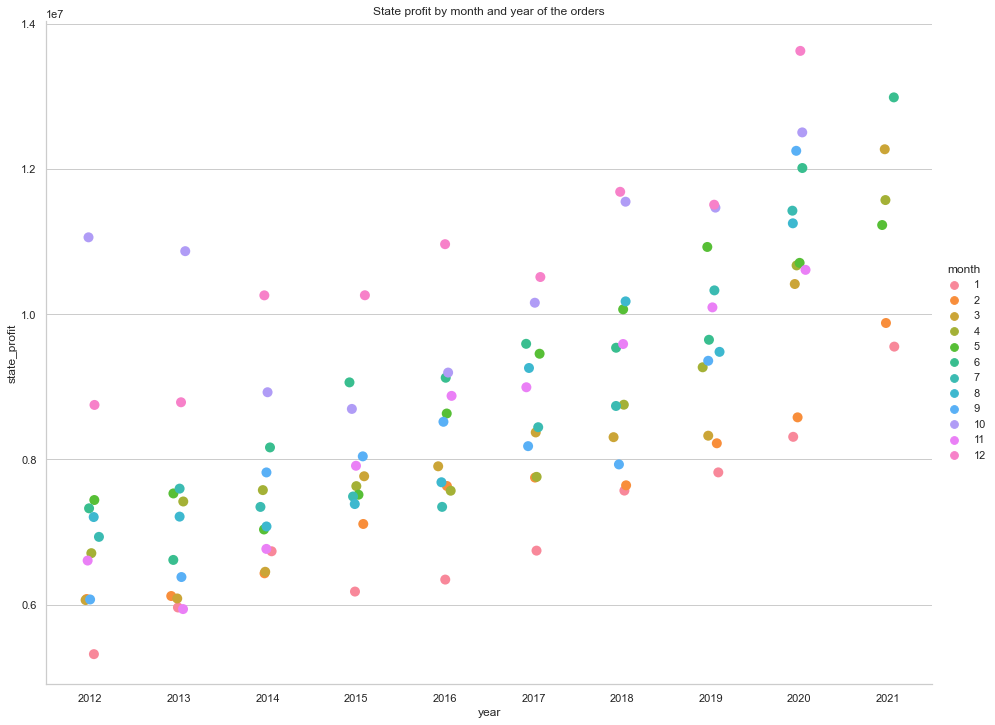

In [22]:
sns.catplot(x="year", y="state_profit", hue="month",data=subset, height = 10, aspect = 1.3, s=10)
plt.title('State profit by month and year of the orders')
plt.show()

### Monthly Time-Series Decomposition

In [23]:
df = df[['state_profit']]
df.index = pd.to_datetime(df.index)

In [24]:

df_m = df.resample('M').sum()

df_m.reset_index(inplace=True)
df_m['Date'] = pd.to_datetime(df_m['Date'])
df_m = df_m.set_index('Date')
    
df_m

,state_profit
Date,
2012-01-31,5320216.31
2012-02-29,6079004.91
2012-03-31,6064927.47
2012-04-30,6710304.28
2012-05-31,7442166.62
...,...
2021-02-28,9879334.94
2021-03-31,12271348.59
2021-04-30,11572070.73


In [25]:
def decompose(df_s):
    
    s=seasonal_decompose(df_s)
    rcParams['figure.figsize'] = 15, 12
    s.plot()
    pass
    return s

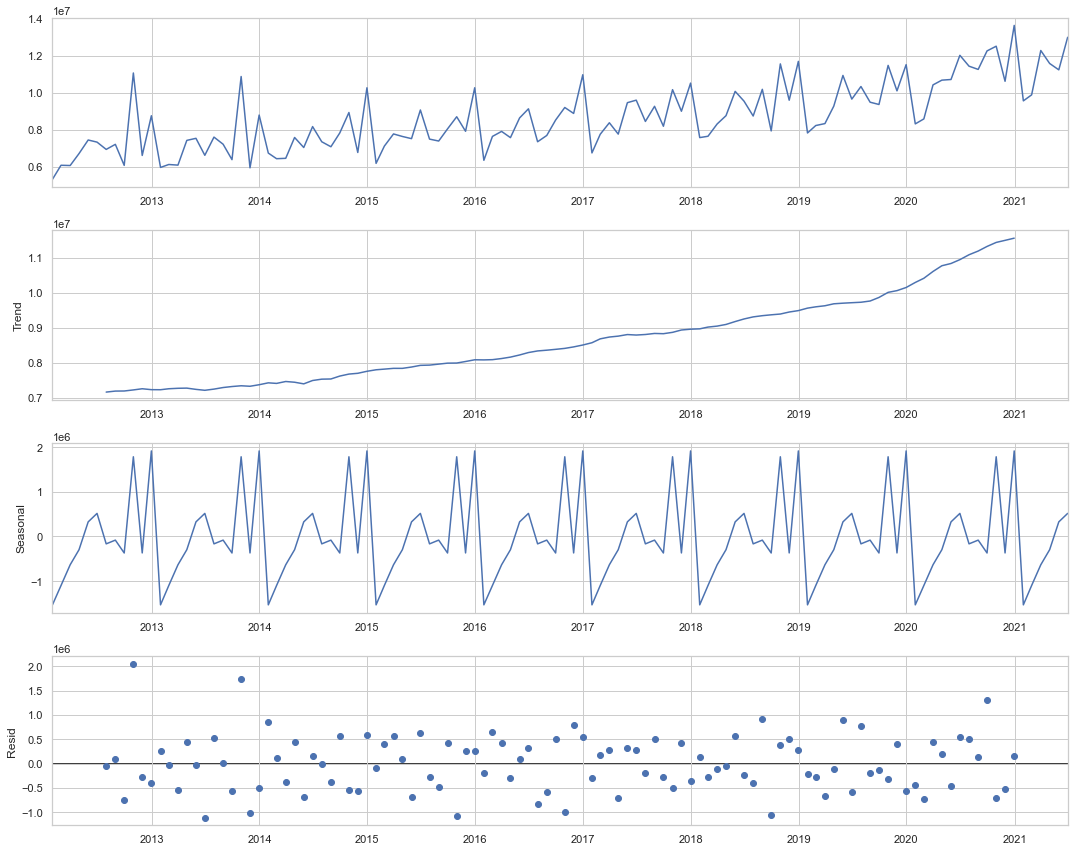

In [26]:
m = decompose(df_m)

We Can se in the monthly Profit Decomposition that the **Trend** is definitely an increasing one, with a higher increase in 2020.

There is a fairly evident **Monthly Seasonality**:
- January has the least profits, but these increase until the Summer month, July and August.
- Towards the eand of the year we have the months with the biggest Sales and Profits: October and Dcember.

The residuals are the values that remain after we deducted the general Trend and Monthly Seasonality.
We can see that generally the residuals are quite low, most of them ranging between -1e6 and 1e6. Considering the ranges of the Trend and Seasonality, we can say that our Profits have a defined clear Monthly Seasonality.

### Weekly Decomposition

Since we have this high Monthly Seasonality let's check if the Weekly Seasonality is as well clearly defined.

In [27]:
df_w = df.resample('W').sum()

df_w.reset_index(inplace=True)
df_w['Date'] = pd.to_datetime(df_w['Date'])
df_w = df_w.set_index('Date')

df_w

,state_profit
Date,
2012-01-08,940141.13
2012-01-15,1181255.09
2012-01-22,1257495.11
2012-01-29,1263748.29
2012-02-05,1389383.64
...,...
2021-06-06,2688185.42
2021-06-13,2981229.17
2021-06-20,2793652.76


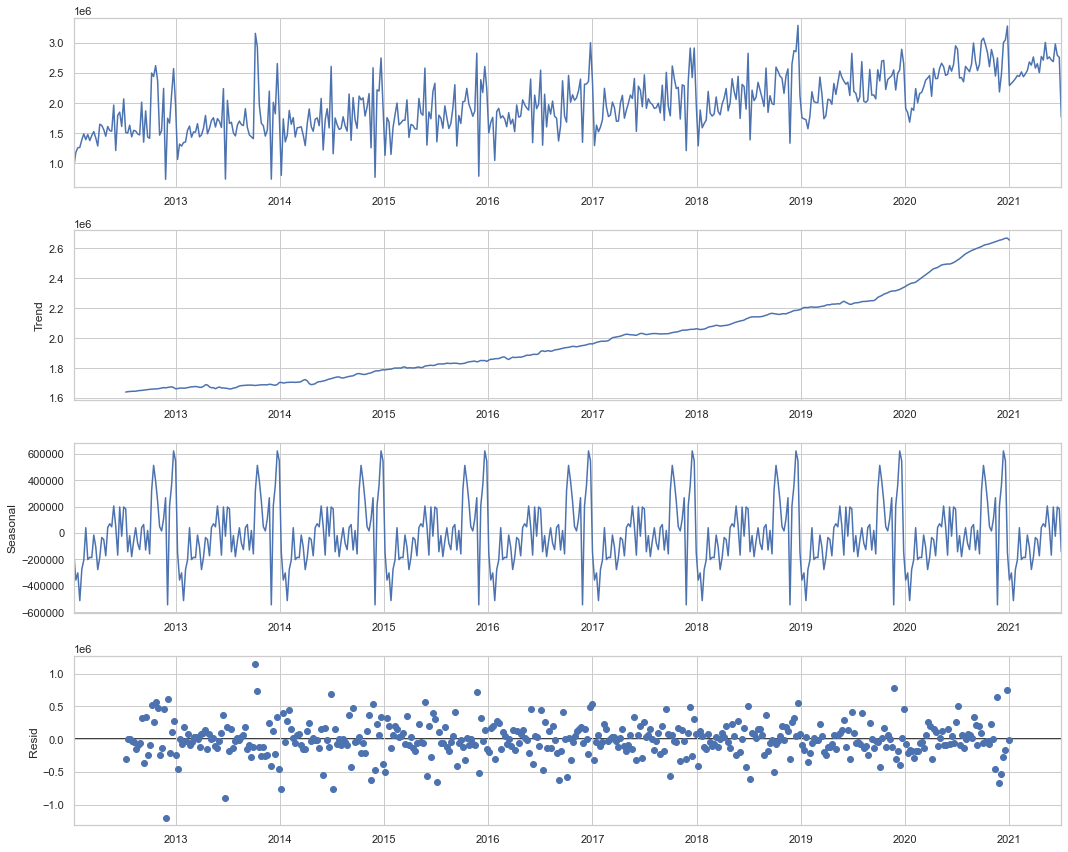

In [28]:
w = decompose(df_w)

We can observe that with the Weekly seasonality, the values of the residuals are often even higher than the ranges of the Seasonality. This means the seasonality variations are not as consistent as those of the weekly aggregates.

Text(0.5, 1.0, 'Monthly and weekly profit Aggregations Seasonality')

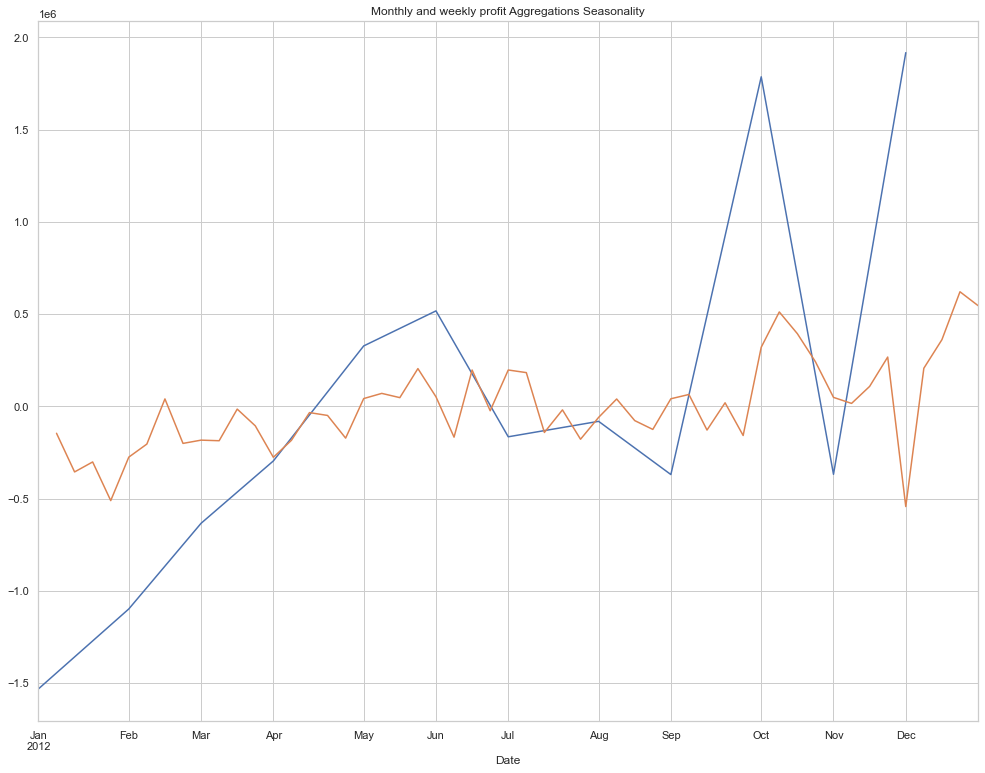

In [29]:
m.seasonal['2012'].plot()
w.seasonal['2012'].plot()
plt.title('Monthly and weekly profit Aggregations Seasonality')

### Quarterly Decomposition

In [30]:
df_q = df.resample('Q').sum()

df_q.reset_index(inplace=True)
df_q['Date'] = pd.to_datetime(df_q['Date'])
df_q = df_q.set_index('Date')

df_q.head()

,state_profit
Date,
2012-03-31,17464148.69
2012-06-30,21480255.66
2012-09-30,20215281.07
2012-12-31,26418809.83
2013-03-31,18169577.47


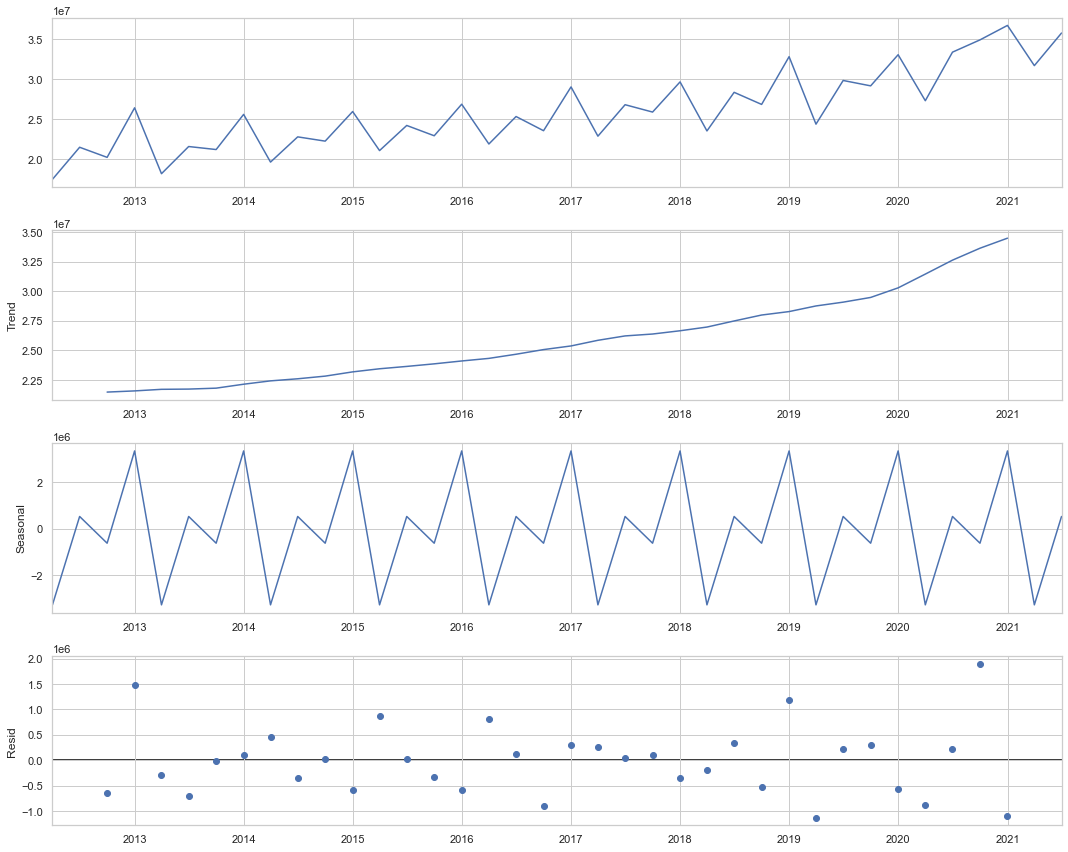

In [31]:
q = decompose(df_q)

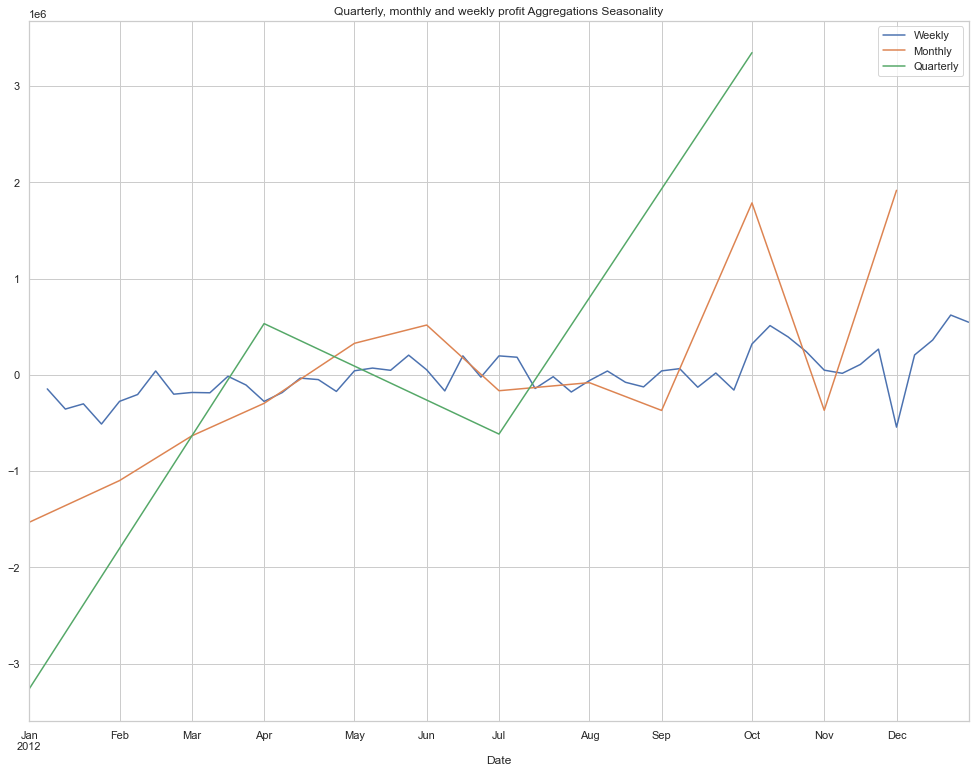

In [32]:
w.seasonal['2012'].plot(label = 'Weekly')
m.seasonal['2012'].plot(label = 'Monthly')
q.seasonal['2012'].plot(label = 'Quarterly')
plt.title('Quarterly, monthly and weekly profit Aggregations Seasonality')
plt.legend()

## Autocorrelation

First we will have to calculate the percentage change of the values.

In [57]:
df['pct_change'] = df['state_profit'].pct_change()
df = df.dropna()
df

,state_profit,pct_change
Date,,
2012-01-04,287668.70,-0.149774
2012-01-05,314128.76,0.091981
2012-01-09,312103.77,-0.006446
2012-01-10,300781.67,-0.036277
2012-01-11,258539.75,-0.140440
...,...,...
2021-06-25,577218.72,0.007852
2021-06-27,14283.09,-0.975255
2021-06-28,651212.68,44.593263


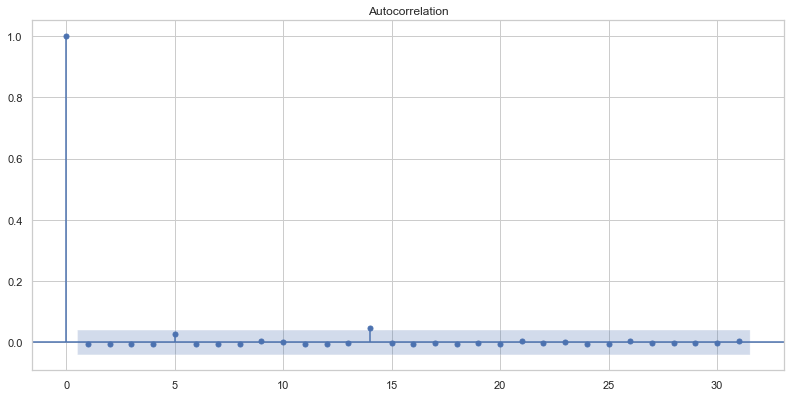

In [66]:
plot_acf(df['pct_change'], lags = 31, alpha = 0.05);

If we plot the daily autocorrelation we can see that we have basically no autocorrelations on our data.
We can say that the percentage changes on the daily aggregations is close to a **White Noise** process.

### Weekly autocorrelations

In [59]:
w = df.resample('W').sum()

w['pct_change'] = w['state_profit'].pct_change()
w = w.dropna()
w

,state_profit,pct_change
Date,,
2012-01-15,1181255.09,0.962878
2012-01-22,1257495.11,0.064542
2012-01-29,1263748.29,0.004973
2012-02-05,1389383.64,0.099415
2012-02-12,1488214.15,0.071133
...,...,...
2021-06-06,2688185.42,-0.010137
2021-06-13,2981229.17,0.109012
2021-06-20,2793652.76,-0.062919


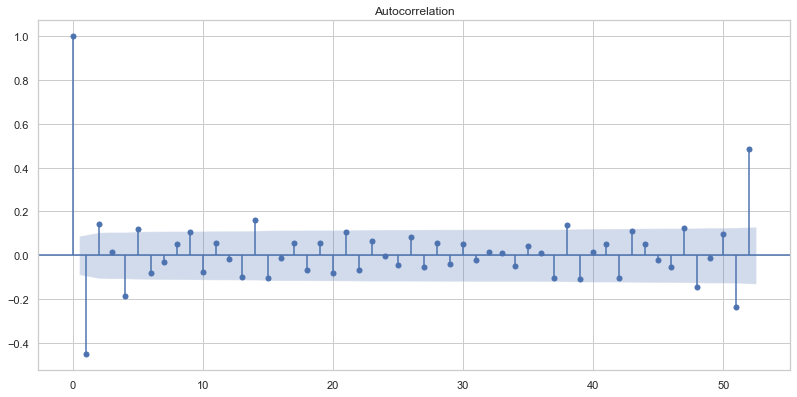

In [67]:
plot_acf(w['pct_change'], lags = 52, alpha = 0.05);

We can see a positive autocorrelation on the 52nd record, that means there is a yearly seasonality.

Also we see a negative autocorrelationon week 1, whick means that after a week had some nice profits, ussualy it comes one without. And the other way around.

That is exactly the statistical priciple of **Regression to the mean** that explains why different natural processes have the tendancy to regress to their mean after an extreme value.

### Monthly autocorrelations

In [64]:
m = df.resample('M').sum()

m['pct_change'] = m['state_profit'].pct_change()
m = m.dropna()
m

,state_profit,pct_change
Date,,
2012-02-29,6079004.91,0.220225
2012-03-31,6064927.47,-0.002316
2012-04-30,6710304.28,0.106411
2012-05-31,7442166.62,0.109065
2012-06-30,7327784.76,-0.015369
...,...,...
2021-02-28,9879334.94,0.034039
2021-03-31,12271348.59,0.242123
2021-04-30,11572070.73,-0.056985


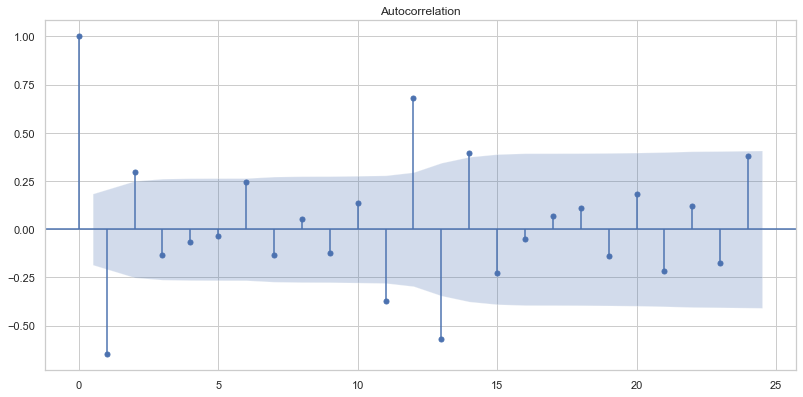

In [68]:
plot_acf(m['pct_change'], lags = 24, alpha = 0.05);

The monthly aggregated data is, as expected, a bit more autocorrelated. Especially a high positive correlation on the 12th period. Again, this is as expected.

the other high autocorrelation is the negative autocorrelation with the 1st period. It is the same situation as with the Weekly aggregations: after a month that had high profits ussualy comes a month without as much.

### Quarterly autocorrelations

In [70]:
q = df.resample('q').sum()

q['pct_change'] = q['state_profit'].pct_change()
q = q.dropna()
q.head()

,state_profit,pct_change
Date,,
2012-06-30,21480255.66,0.254263
2012-09-30,20215281.07,-0.058890
2012-12-31,26418809.83,0.306873
2013-03-31,18169577.47,-0.312248
2013-06-30,21571853.74,0.187251


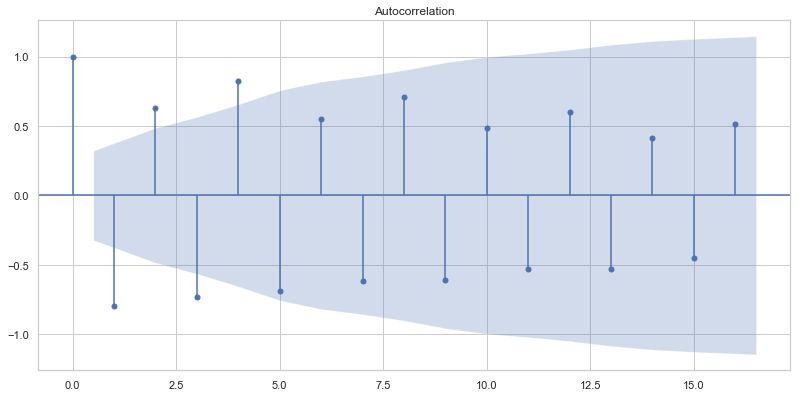

In [72]:
plot_acf(q['pct_change'], alpha = 0.05);

We can see that the **negative autocorrelation** is clearly visible when **Profit is aggregated on Quarters**.

## Random Walk Hypothesis Testing

As we have seen above, the Percentage Change of daily aggregations of the Profit seems to be White Noise. This should happen if our Profit follows a **Random Walk.**

It is important to know if the Daily Profit aggregations follow a Random Walk because **you can't forcast a Random Walk**. The best forecast for tomorrow's value is today's value.

>**Null hypothesis (H0)** : the time series follows a random walk.

>**Alternative hypothesis (H1)** : The time series is stationary.

In [74]:
df

,state_profit,pct_change
Date,,
2012-01-04,287668.70,-0.149774
2012-01-05,314128.76,0.091981
2012-01-09,312103.77,-0.006446
2012-01-10,300781.67,-0.036277
2012-01-11,258539.75,-0.140440
...,...,...
2021-06-25,577218.72,0.007852
2021-06-27,14283.09,-0.975255
2021-06-28,651212.68,44.593263


In [77]:
def adf_test(timeseries):  
    '''Perform Dicky-Fuller test'''
    print('\nResults of Dickey-Fuller Test:')
        
    # Set autolag as BIC, so the number of lags is chosen to minimize the corresponding information criterion
    df_test = adfuller(timeseries, autolag= 'BIC') 


    df_output = pd.Series(df_test[0:4] , index= ['test statistic', 'p-value', '# Lags Used','# Observation Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] = value
    print(df_output)

In [78]:
adf_test(df['state_profit'])


Results of Dickey-Fuller Test:
test statistic       -7.863302e+00
p-value               5.214274e-12
# Lags Used           1.200000e+01
# Observation Used    2.331000e+03
Critical Value 1%    -3.433158e+00
Critical Value 5%    -2.862781e+00
Critical Value 10%   -2.567430e+00
dtype: float64


With a p - value close to 0 we reject the **Null Hypothesis** and we can conclude that our daily profit aggregation are not following a **Random Walk**.

## Validation set

So far from the start of the exercise we worked with data from 2012 to June 30th 2021. We recently checked and on Iowa.gov website they recently uploaded another batch of data, containing Sales from **July 2021**.

since this data was not used in any of our analysis, it is the perfect candidate for the **Validation Set**.

Let's load this and clean the data.

In [139]:
validation = pd.read_csv('../data/raw/Iowa_Liquor_Sales July2021.csv', parse_dates = True)
validation

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,INV-37978100001,7/1/2021,3829,Gary's Foods / Mt Vernon,715 1st Ave S,Mount Vernon,52314,NaN,57,LINN,...,5290,J & B Rare Scotch,12,750,12.25,18.38,3,55.14,2.25,0.59
1,INV-37993100030,7/1/2021,5465,Kum & Go #1215 / Ames,4506 Lincoln Way,Ames,50010,NaN,85,STORY,...,36304,Hawkeye Vodka,24,375,1.86,2.79,4,11.16,1.50,0.39
2,INV-37993500004,7/1/2021,4656,Casey's General Store #2301 / Ames,17005 Hwy 69,Ames,50010,NaN,85,STORY,...,43024,Admiral Nelson Spiced,24,375,2.99,4.49,24,107.76,9.00,2.37
3,INV-37973700077,7/1/2021,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,...,45248,Paramount Gold Rum,6,1750,7.50,11.25,6,67.50,10.50,2.77
4,INV-37969700044,7/1/2021,5314,Tobacco Hut & Liquor,3134 Manawa Center Dr. # 9,Council Bluffs,51501,POINT (-95.847514 41.228712),78,POTTAWATTA,...,35926,Five O'Clock Vodka PET,12,750,3.37,5.06,6,30.36,4.50,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212857,INV-38831600011,7/30/2021,6166,Dannys Tobacco & Liquor / Guttenberg,531 U.S. 52,Guttenberg,52052,NaN,22,CLAYTON,...,36308,Hawkeye Vodka,6,1750,7.17,10.76,6,64.56,10.50,2.77
212858,INV-38836300013,7/30/2021,4069,Fareway Stores #648 / Ottumwa,1325 Albia Rd,Ottumwa,52501,POINT (-92.440213 41.00934),90,WAPELLO,...,40599,New Amsterdam Red Berry,12,750,7.50,11.25,4,45.00,3.00,0.79
212859,INV-38819700035,7/30/2021,3514,Karen's Spirits and Wine,328 2nd Ave S,Fort Dodge,50501,POINT (-94.192501 42.502311),94,WEBSTER,...,37996,Smirnoff 80prf,12,750,8.25,12.38,2,24.76,1.50,0.39
212860,INV-38826500015,7/30/2021,4934,Casey's General Store #2811 / Springville,605 6th St S,Springville,52336,POINT (-91.443745 42.050954),57,LINN,...,36904,McCormick 80prf Vodka PET,24,375,1.80,2.70,8,21.60,3.00,0.79


In [140]:
validation['state_profit'] =  (validation['State Bottle Retail'] - validation['State Bottle Cost']) * validation['Bottles Sold']

In [141]:
validation.head().T

,0,1,2,3,4
Invoice/Item Number,INV-37978100001,INV-37993100030,INV-37993500004,INV-37973700077,INV-37969700044
Date,7/1/2021,7/1/2021,7/1/2021,7/1/2021,7/1/2021
Store Number,3829,5465,4656,2538,5314
Store Name,Gary's Foods / Mt Vernon,Kum & Go #1215 / Ames,Casey's General Store #2301 / Ames,Hy-Vee Food Store #3 / Waterloo,Tobacco Hut & Liquor
Address,715 1st Ave S,4506 Lincoln Way,17005 Hwy 69,1422 Flammang Dr,3134 Manawa Center Dr. # 9
City,Mount Vernon,Ames,Ames,Waterloo,Council Bluffs
Zip Code,52314,50010,50010,50702,51501
Store Location,NaN,NaN,NaN,POINT (-92.327917 42.459938),POINT (-95.847514 41.228712)
County Number,57,85,85,7,78
County,LINN,STORY,STORY,BLACK HAWK,POTTAWATTA


In [145]:
validation = validation.groupby('Date')['state_profit'].sum()
validation               

Date
7/1/2021     523871.28
7/11/2021      4483.79
7/12/2021    440662.66
7/13/2021    497241.58
7/14/2021    648845.53
7/15/2021    467958.67
7/16/2021    427222.59
7/18/2021      2765.07
7/19/2021    421307.16
7/2/2021     544700.35
7/20/2021    611883.15
7/21/2021    691006.28
7/22/2021    501054.41
7/23/2021    483071.22
7/25/2021      1363.88
7/26/2021    491530.00
7/27/2021    475522.00
7/28/2021    532262.18
7/29/2021    444925.64
7/30/2021    571680.00
7/4/2021       2947.96
7/5/2021     597425.16
7/6/2021     451192.81
7/7/2021     765833.39
7/8/2021     666462.03
7/9/2021     457611.57
Name: state_profit, dtype: float64

## Model Evaluation

We will evaluate the performance of predictions using the root mean squared error (RMSE). This will give more weight to predictions that are grossly wrong and will have the same units as the original data.

Any transforms to the data must be reversed before the RMSE is calculated and reported to make the performance between different methods directly comparable.

We can calculate the RMSE using the helper function from the scikit-learn library mean_squared_error() that calculates the mean squared error between a list of expected values (the test set) and the list of predictions. We can then take the square root of this value to give us an RMSE score.

To compare the optimal models, the following measurements are calculated for each one:
* **root-mean-square error (RMSE)**
* **mean absolute error(MAE)**
* **mean absolute percentage error(MAPE)**
* **r2_score**: Unlike most other scores, R^2 score may be negative (it need not actually be the square of a quantity R).

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''calculae MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def evaluation(y_actual, y_pred):
    '''calculate evaluation metrics'''
    rmse = round(np.sqrt(mean_squared_error(y_actual, y_pred)),3)
    mae = round(mean_absolute_error(y_actual, y_pred),3)
    mape = round(mean_absolute_percentage_error(y_actual, y_pred),2)
    r2 = round(np.corrcoef(y_actual, y_pred)[0,1],2)
  
    return rmse,mae,mape,r2

# Modeling

### Naive Model

## Autoregressive (AR) model

### AR(1)

In [102]:
model = ARMA(df['state_profit'], order = (1,0))
result = model.fit()

In [103]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           state_profit   No. Observations:                 2344
Model:                     ARMA(1, 0)   Log Likelihood              -31209.669
Method:                       css-mle   S.D. of innovations         146644.414
Date:                Tue, 10 Aug 2021   AIC                          62425.338
Time:                        22:58:20   BIC                          62442.617
Sample:                             0   HQIC                         62431.632
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.225e+05   3210.849    131.587      0.000    4.16e+05    4.29e+05
ar.L1.state_profit     0.0567      0.021      2.748      0.006       0.016       0.097
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           17.6407           +0.0000j           17.6407            0.0000
-----------------------------------------------------------------------------
"""

In [104]:
df

,state_profit,pct_change
Date,,
2012-01-04,287668.70,-0.149774
2012-01-05,314128.76,0.091981
2012-01-09,312103.77,-0.006446
2012-01-10,300781.67,-0.036277
2012-01-11,258539.75,-0.140440
...,...,...
2021-06-25,577218.72,0.007852
2021-06-27,14283.09,-0.975255
2021-06-28,651212.68,44.593263


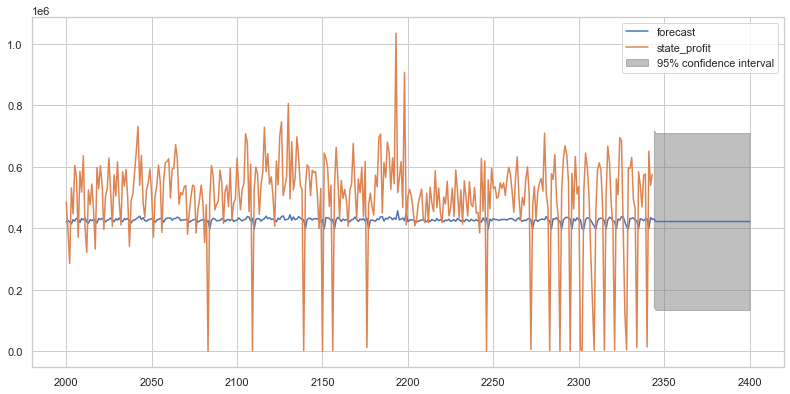

In [108]:
result.plot_predict(start = 2000, end = 2400);

Now let's use this model with our monthly data

In [121]:
data = df[['state_profit']].resample('m').sum()

data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

data

,state_profit
Date,
2012-01-31,4981872.64
2012-02-29,6079004.91
2012-03-31,6064927.47
2012-04-30,6710304.28
2012-05-31,7442166.62
...,...
2021-02-28,9879334.94
2021-03-31,12271348.59
2021-04-30,11572070.73


In [122]:
model = ARMA(data, order = (1,0))
result = model.fit()

In [123]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           state_profit   No. Observations:                  114
Model:                     ARMA(1, 0)   Log Likelihood               -1788.667
Method:                       css-mle   S.D. of innovations        1574952.285
Date:                Tue, 10 Aug 2021   AIC                           3583.335
Time:                        23:11:15   BIC                           3591.543
Sample:                    01-31-2012   HQIC                          3586.666
                         - 06-30-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8.687e+06   3.05e+05     28.458      0.000    8.09e+06    9.29e+06
ar.L1.state_profit     0.5213      0.084      6.215      0.000       0.357       0.686
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9181           +0.0000j            1.9181            0.0000
-----------------------------------------------------------------------------
"""

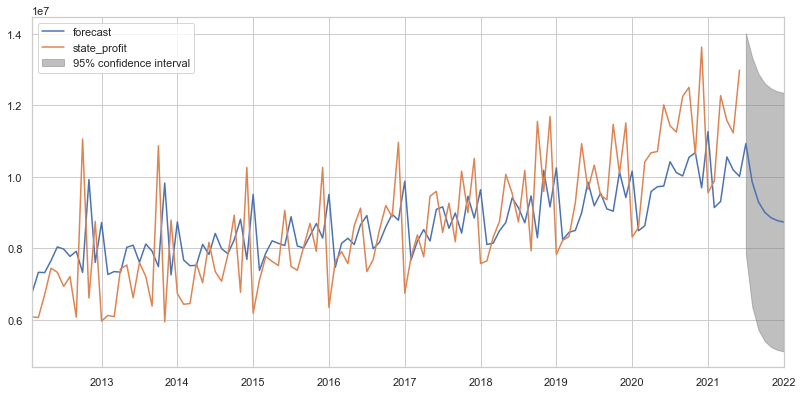

In [124]:
result.plot_predict(start = 1, end = 120);

## Information Criteria

It adjusts goodness-of-fit for number of parameters

Two popular adjusted goodness-of-fit measures:
* AIC( Akaike Information Criterion)
* BIC(Bayesian Information Criterion)

The BIC values have to be minimized to reduce overfitting on our training data.

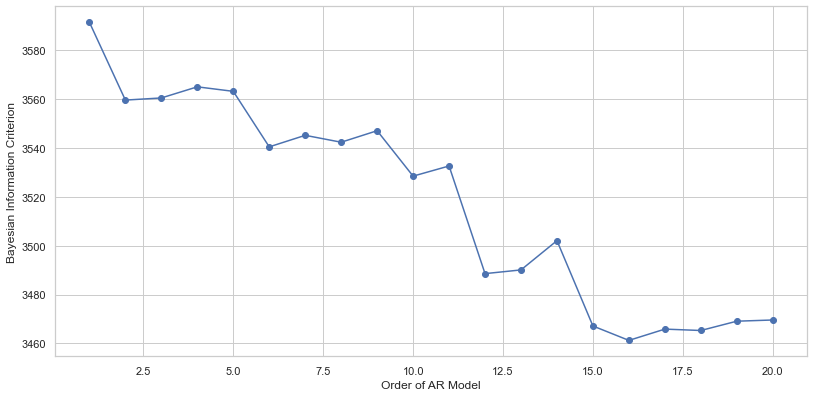

In [128]:
# Fit the data to an AR(p) for p = 0,...,10 , and save the BIC
BIC = np.zeros(21)
for p in range(21):
    mod = ARMA(data, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,21), BIC[1:21], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

### AR16

We see that the **minimum BIC is at AR of order 16.**

In [129]:
mod16 = ARMA(data, order=(16,0))
res = mod.fit()

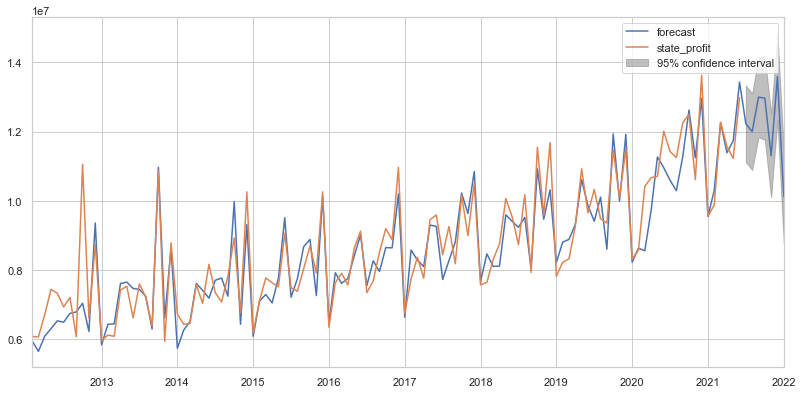

In [130]:
res.plot_predict(start = 1, end = 120);

## Moving Average (MA) Model

In [132]:
mod = ARMA(data, order=(0,1))
res = mod.fit()

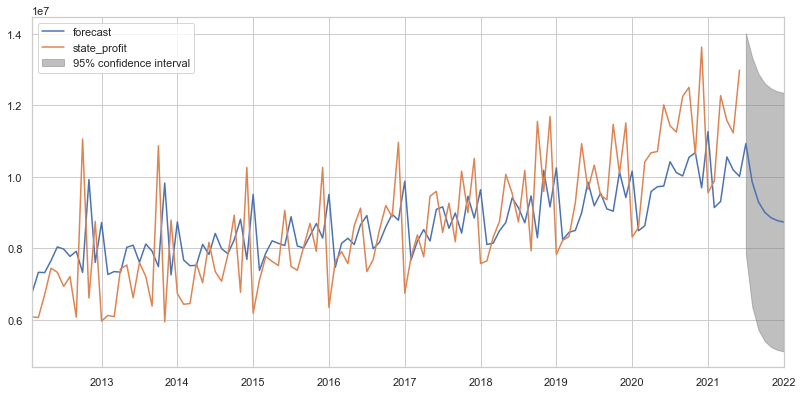

In [133]:
result.plot_predict(start = 1, end = 120);